## Initialization

In [1]:
import scm.plams as plams
import os
import numpy as np
import matplotlib.pyplot as plt
import scm.params as params
from scm.simple_active_learning import SimpleActiveLearningJob

In [2]:
plams.init()

PLAMS working folder: /home/hellstrom/temp/sal-lidiff-qMr-2024-Mar-14/clean/plams_workdir.007


## Create structures

### Create primitive cell from coordinates

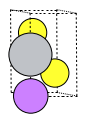

In [3]:
# for plotting in Jupyter notebooks
rotation = "-85x,-5y,0z"

# create structure
primitive = plams.AMSJob.from_input(
    """
    System
        Atoms
            Li 0. 0. 0.
            Ti 0. 0. 3.087452499999999 
            S 0. 1.985103430533333 4.551328274799999 
            S 1.71915 0.9925517153000001 1.6235767252 
        End
        Lattice
            3.4383 0.0 0.0
            -1.71915 2.977655145833333 0.0
            0.0 0.0 6.174905
        End
    End
"""
).molecule[""]
plams.plot_molecule(primitive, rotation=rotation)

### Create a supercell.

Here we a reasonably-sized supercell.  If the cell is very small, it is actually quite inefficient for training the machine learning potential. If every atom sees its own periodic image then there will not be sufficient variety in the atomic environments for the ML potential to be able to extrapolate to unseen environments. **It is recommended to use a larger supercell**.

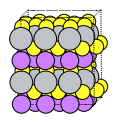

In [4]:
supercell = primitive.supercell([[3, 0, 0], [2, 4, 0], [0, 0, 2]])
for at in supercell:
    at.properties = plams.Settings()
plams.plot_molecule(supercell, rotation=rotation)

In [5]:
print("Lattice vectors")
print(supercell.lattice)
print(f"Number of atoms: {len(supercell)}")

Lattice vectors
[(10.3149, 0.0, 0.0), (0.0, 11.910620583333332, 0.0), (0.0, 0.0, 12.34981)]
Number of atoms: 96


### Create Li vacancy in two different places

In [6]:
li_indices = [i for i, at in enumerate(supercell, 1) if at.symbol == "Li"]
print(f"Li indices (starting with 1): {li_indices}")

Li indices (starting with 1): [1, 5, 9, 13, 17, 21, 25, 29, 33, 37, 41, 45, 49, 53, 57, 61, 65, 69, 73, 77, 81, 85, 89, 93]


Pick the first Li atom, and get its nearest Li neighbor.

Note that the PLAMS distance_to function ignores periodic boundary conditions, which in this case is quite convenient as it will make the visualization easier if the Li atom diffuses inside the unit cell and doesn't cross the periodic boundary.

In [7]:
first_index = li_indices[0]
li1 = supercell[first_index]
li1.properties.region = "DiffusingLi"
distances = [li1.distance_to(supercell[x]) for x in li_indices[1:]]
nearest_neighbor_index = li_indices[np.argmin(distances) + 1]
li2 = supercell[nearest_neighbor_index]
target_coords = li2.coords
print(f"First Li atom: {li1}")
print(f"Second Li atom: {li2}")

First Li atom:         Li       0.000000       0.000000       0.000000 
Second Li atom:         Li       3.438300       0.000000       0.000000 


The goal is to make a Li atom diffuse between these two positions.

For this, we will first delete the second Li atom, and then create a new structure in which the first Li atom is translated to the second Li atom coordinates.

In [8]:
defective_1 = supercell.copy()
defective_1.delete_atom(defective_1[nearest_neighbor_index])
defective_2 = supercell.copy()
defective_2.delete_atom(defective_2[nearest_neighbor_index])
defective_2[first_index].coords = li2.coords

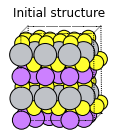

In [9]:
plams.plot_molecule(defective_1, rotation=rotation)
plt.title("Initial structure");

The Li atom in the bottom left corner will diffuse to the right (the vacancy will diffuse to the left):

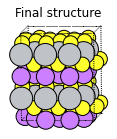

In [10]:
plams.plot_molecule(defective_2, rotation=rotation)
plt.title("Final structure");

## Initial validation of diffusion barrier with NEB and M3GNet-UP-2022

### M3GNet-UP-2022 NEB job

In [11]:
m3gnet_up_s = plams.Settings()
m3gnet_up_s.input.MLPotential.Model = "M3GNet-UP-2022"

neb_s = plams.Settings()
neb_s.input.ams.Task = "NEB"
neb_s.input.ams.NEB.PreoptimizeWithIDPP = "Yes"
neb_s.input.ams.NEB.Images = 7

In [12]:
m3gnet_up_neb_job = plams.AMSJob(
    settings=m3gnet_up_s + neb_s,
    molecule={"": defective_1, "final": defective_2},
    name="m3gnet_up_neb",
)
m3gnet_up_neb_job.run();

[25.03|10:51:33] JOB m3gnet_up_neb STARTED
[25.03|10:51:33] JOB m3gnet_up_neb RUNNING
[25.03|10:51:58] JOB m3gnet_up_neb FINISHED
[25.03|10:51:58] JOB m3gnet_up_neb SUCCESSFUL


### M3GNet-UP-2022 NEB results

In [13]:
m3gnet_up_res = m3gnet_up_neb_job.results.get_neb_results(unit="eV")
print(f"Left barrier: {m3gnet_up_res['LeftBarrier']:.3f} eV")
print(f"Right barrier: {m3gnet_up_res['RightBarrier']:.3f} eV")

Left barrier: 0.388 eV
Right barrier: 0.388 eV


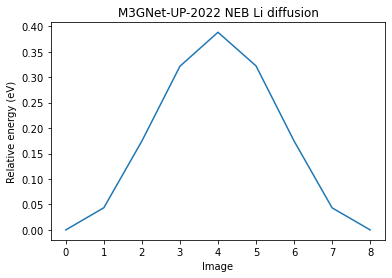

In [14]:
# ref_results = [0.0, 0.144, 0.482, 0.816, 0.963, 0.816, 0.482, 0.144, 0.0]  # from Quantum ESPRESSO DFT calculation
nImages = m3gnet_up_res["nImages"]
relative_energies = np.array(m3gnet_up_res["Energies"]) - m3gnet_up_res["Energies"][0]
plt.plot(relative_energies)
plt.xlabel("Image")
plt.ylabel("Relative energy (eV)")
plt.title("M3GNet-UP-2022 NEB Li diffusion");

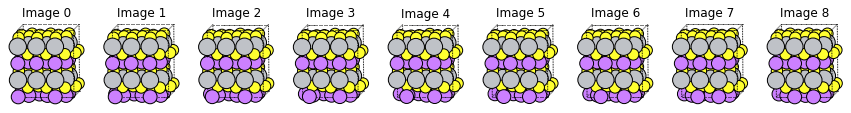

In [15]:
fig, axes = plt.subplots(1, len(m3gnet_up_res["Molecules"]), figsize=(15, 5))

for i, mol in enumerate(m3gnet_up_res["Molecules"]):
    plams.plot_molecule(mol, ax=axes[i], rotation=rotation)
    axes[i].set_title(f"Image {i}")

In [16]:
!amsmovie "{m3gnet_up_neb_job.results.rkfpath()}"

## DFT reference engine settings

Are the above M3GNet-UP-2022 results any good? Let's compare to DFT calculations using the AMS "Replay" task.

"Replay" is just a series of singlepoints on the previous NEB structures. It is not a NEB calculation.

Here we use the Quantum ESPRESSO engine available in AMS2024.

In [17]:
dft_s = plams.Settings()
dft_s.input.QuantumESPRESSO.System.occupations = "Smearing"
dft_s.input.QuantumESPRESSO.System.degauss = 0.005
# for production purposes always manually check that ecutwfc and ecutrho are high enough
# here we set a fairly low ecutwfc to speed up the calculation
dft_s.input.QuantumESPRESSO.System.ecutwfc = 30.0
dft_s.input.QuantumESPRESSO.System.ecutrho = 240.0
# decrease mixing_beta for more robust SCF convergence
dft_s.input.QuantumESPRESSO.Electrons.mixing_beta = 0.3
dft_s.input.QuantumESPRESSO.Electrons.conv_thr = 1.0e-5 * len(supercell)
# for a small cell one should ideally use more k-points than just the gamma point
# by settings K_Points._h = "gamma" we use the faster gamma-point-only
# implementation in Quantum ESPRESSO
dft_s.input.QuantumESPRESSO.K_Points._h = "gamma"
# SCM_DISABLE_MPI launches ams in serial, but will still run Quantum ESPRESSO in parallel
dft_s.runscript.preamble_lines = ["export SCM_DISABLE_MPI=1"]

## Run DFT calculations on the NEB points from M3GNet-UP-2022

Note: The DFT calculations may take a few minutes to complete.

In [18]:
replay_s = plams.Settings()
replay_s.input.ams.Task = "Replay"
replay_s.input.ams.Replay.File = os.path.abspath(m3gnet_up_neb_job.results.rkfpath())
replay_s.input.ams.Properties.Gradients = "Yes"

replay_dft_job = plams.AMSJob(settings=replay_s + dft_s, name="replay_m3gnet_up_neb_with_dft")
replay_dft_job.run(watch=True);

[25.03|10:52:07] JOB replay_m3gnet_up_neb_with_dft STARTED
[25.03|10:52:07] JOB replay_m3gnet_up_neb_with_dft RUNNING
[25.03|10:52:07] replay_m3gnet_up_neb_with_dft: AMS 2024.101  RunTime: Mar25-2024 10:52:07  ShM Nodes: 1  Procs: 1
[25.03|10:52:07] replay_m3gnet_up_neb_with_dft: Starting trajectory replay ...
[25.03|10:52:07] replay_m3gnet_up_neb_with_dft: Replaying frame #1/9 (#342 in original trajectory)
[25.03|10:52:07] replay_m3gnet_up_neb_with_dft:     NOTE: a single QE.Label is assigned to atoms of different species.
[25.03|10:52:07] replay_m3gnet_up_neb_with_dft:     Pseudopotentials: /home/hellstrom/.scm/packages/AMS2024.1.packages/qe-ky3v91ot/content/upf_files
[25.03|10:52:08] replay_m3gnet_up_neb_with_dft:     AMS Pseudopotentials Finder:
[25.03|10:52:08] replay_m3gnet_up_neb_with_dft:       * Li
[25.03|10:52:08] replay_m3gnet_up_neb_with_dft:         Path: GGA/PBE/SR/SSSP_Efficiency_v1.3.0/UPFs
[25.03|10:52:08] replay_m3gnet_up_neb_with_dft:         File: li_pbe_v1.4.uspp.F

When using "Replay" on a NEB job, the results are stored in the normal NEB format. Thus we can use the ``.get_neb_results()`` method also on this job:

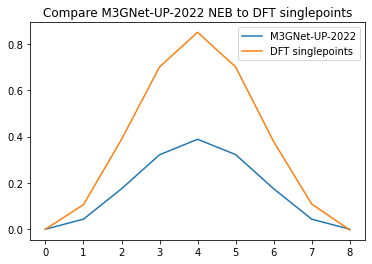

In [19]:
dft_energies = replay_dft_job.results.get_neb_results(unit="eV")["Energies"]
dft_relative_energies = np.array(dft_energies) - dft_energies[0]

plt.plot(relative_energies)
plt.plot(dft_relative_energies)
plt.legend(["M3GNet-UP-2022", "DFT singlepoints"])
plt.title("Compare M3GNet-UP-2022 NEB to DFT singlepoints");

**Conclusion**: M3GNet-UP-2022 significantly underestimates the diffusion barrier compared to DFT calculations. **This motivates the reparametrization**

## Store DFT results for later

Since we already performed some DFT calculations, we may as well add them to the training set.

In [20]:
ri = params.ResultsImporter(settings={"units": {"energy": "eV", "forces": "eV/angstrom"}})
ri.add_trajectory_singlepoints(
    replay_dft_job,
    properties=["energy", "forces"],
    indices=[0, 1, 2, 3, 4],
    data_set="training_set",
)
ri.add_trajectory_singlepoints(
    replay_dft_job, properties=["energy", "forces"], indices=[5], data_set="validation_set"
)
yaml_dir = "lidiffusion_initial_reference_data"
ri.store(yaml_dir, backup=False)

['lidiffusion_initial_reference_data/job_collection.yaml',
 'lidiffusion_initial_reference_data/results_importer_settings.yaml',
 'lidiffusion_initial_reference_data/training_set.yaml',
 'lidiffusion_initial_reference_data/validation_set.yaml']

## Preliminary active learning jobs with equilibrium MD

Let's first run some simple NVT MD with active learning for both the
* stochiometric system (``supercell``), and
* defective system (``defective_1``)

This is just to get a good general sampling before setting up the reaction boost to explicitly sample the diffusion process.

### Active Learning for stoichiometric system

The stoichiometric system is a perfect crystal with not so many atoms. The forces will be very close to 0 also after a few MD frames. However, even if the ML model predicts forces close to 0, the R^2 between predicted and reference forces may be quite low.

In a case like this, it is reasonable to either

* decrease the MinR2 success criterion, and/or
* perturb the atomic coordinates of the initial structure a bit, so that the forces aren't extremely small

Here, we do both of these:

In [21]:
nvt_md_s = plams.AMSNVTJob(
    nsteps=5000, timestep=0.5, temperature=400, tau=50, thermostat="Berendsen"
).settings

prelim_al_s = plams.Settings()
prelim_al_s.input.ams.ActiveLearning.InitialReferenceData.Load.Directory = os.path.abspath(yaml_dir)
prelim_al_s.input.ams.ActiveLearning.Steps.Type = "Geometric"
prelim_al_s.input.ams.ActiveLearning.Steps.Geometric.NumSteps = 7
prelim_al_s.input.ams.ActiveLearning.SuccessCriteria.Forces.MinR2 = 0.5
prelim_al_s.input.ams.ActiveLearning.AtEnd.RerunSimulation = "No"

ml_s = plams.Settings()
ml_s.input.ams.MachineLearning.Backend = "M3GNet"
ml_s.input.ams.MachineLearning.M3GNet.Model = "UniversalPotential"
ml_s.input.ams.MachineLearning.MaxEpochs = 100
ml_s.input.ams.MachineLearning.Target.Forces.MAE = 0.04

perturbed_supercell = supercell.copy()
perturbed_supercell.perturb_atoms(0.1)

prelim_al_job = SimpleActiveLearningJob(
    name="al_supercell",
    molecule=perturbed_supercell,
    settings=prelim_al_s + ml_s + nvt_md_s + dft_s,
)
prelim_al_job.run(watch=True);

[25.03|11:05:28] JOB al_supercell STARTED
[25.03|11:05:28] JOB al_supercell RUNNING
[25.03|11:05:29] Simple Active Learning 2024.101,  Nodes: 1, Procs: 8
[25.03|11:05:31] Composition of main system: Li24S48Ti24
[25.03|11:05:31] All REFERENCE calculations will be performed with the following QuantumESPRESSO engine:
[25.03|11:05:31]
Engine quantumespresso
  electrons
    conv_thr 0.0009600000000000001
    mixing_beta 0.3
  End
  k_points gamma
  End
  system
    degauss 0.005
    ecutrho 240.0
    ecutwfc 30.0
    occupations Smearing
  End
EndEngine


[25.03|11:05:31] The following are the settings for the to-be-trained MACHINE LEARNING model:
[25.03|11:05:31]
MachineLearning
  Backend M3GNet
  M3GNet
    Model UniversalPotential
  End
  MaxEpochs 100
  Target
    Forces
      MAE 0.04
    End
  End
End

ParallelLevels
End

[25.03|11:05:31] A single model will be trained (no committee).
[25.03|11:05:31] The ACTIVE LEARNING loop will contain 7 steps, using the following schema:
[25.03|11

### Active learning for defective system

In [22]:
prelim_al_s2 = prelim_al_s.copy()
prelim_al_s2.input.ams.ActiveLearning.InitialReferenceData.Load.Directory = (
    prelim_al_job.results.get_reference_data_directory()
)
prelim_al_s2.input.ams.ActiveLearning.InitialReferenceData.Load.FromPreviousModel = "No"
prelim_al_s2.input.ams.ActiveLearning.SuccessCriteria.Forces.MaxDeviationForZeroForce = 0.35

ml_s2 = plams.Settings()
ml_s2.input.ams.MachineLearning.Backend = "M3GNet"
ml_s2.input.ams.MachineLearning.LoadModel = prelim_al_job.results.get_params_results_directory()
ml_s2.input.ams.MachineLearning.MaxEpochs = 200
ml_s2.input.ams.MachineLearning.Target.Forces.MAE = 0.03

prelim_al_job2 = SimpleActiveLearningJob(
    name="al_defective", molecule=defective_1, settings=prelim_al_s2 + ml_s2 + nvt_md_s + dft_s
)
prelim_al_job2.run(watch=True);

[25.03|11:40:18] JOB al_defective STARTED
[25.03|11:40:18] JOB al_defective RUNNING
[25.03|11:40:20] Simple Active Learning 2024.101,  Nodes: 1, Procs: 8
[25.03|11:40:22] Composition of main system: Li23S48Ti24
[25.03|11:40:22] All REFERENCE calculations will be performed with the following QuantumESPRESSO engine:
[25.03|11:40:22]
Engine quantumespresso
  electrons
    conv_thr 0.0009600000000000001
    mixing_beta 0.3
  End
  k_points gamma
  End
  system
    degauss 0.005
    ecutrho 240.0
    ecutwfc 30.0
    occupations Smearing
  End
EndEngine


[25.03|11:40:22] The following are the settings for the to-be-trained MACHINE LEARNING model:
[25.03|11:40:22]
MachineLearning
  Backend M3GNet
  LoadModel /home/hellstrom/temp/sal-lidiff-qMr-2024-Mar-14/clean/plams_workdir.007/al_supercell/step7_attempt1_training/results
  MaxEpochs 200
  Target
    Forces
      MAE 0.03
    End
  End
End

ParallelLevels
End

[25.03|11:40:22] A single model will be trained (no committee).
[25.03|11:40:22]

## Set up ReactionBoost MD simulation with M3GNet-UP-2022

ReactionBoost simulations can be a bit tricky to set up.

Before using ReactionBoost inside the Active Learning, it is best to verify that the simulation behaves reasonably when using M3GNet-UP-2022.

So let's just run a normal ReactionBoost simulation with M3GNet-UP-2022:

In [23]:
md_s = plams.Settings()
md_s.Thermostat.Temperature = 300
md_s.Thermostat.Type = "Berendsen"
md_s.Thermostat.Tau = 5
md_s.InitialVelocities.Type = "Random"
md_s.InitialVelocities.Temperature = 300
md_s.ReactionBoost.Type = "RMSD"
md_s.ReactionBoost.NSteps = 480
md_s.ReactionBoost.Region = "DiffusingLi"
md_s.ReactionBoost.TargetSystem = "final"
md_s.ReactionBoost.RMSDRestraint.Type = "Harmonic"
md_s.ReactionBoost.RMSDRestraint.Harmonic.ForceConstant = 0.1
md_s.NSteps = 500
md_s.TimeStep = 0.5
md_s.Trajectory.SamplingFreq = 20
rb_s = plams.Settings()
rb_s.input.ams.Task = "MolecularDynamics"
rb_s.input.ams.MolecularDynamics = md_s

In [24]:
m3gnet_rb_job = plams.AMSJob(
    settings=m3gnet_up_s + rb_s,
    name="m3gnet_up_rb",
    molecule={"": defective_1, "final": defective_2},
)
m3gnet_rb_job.run();

[25.03|12:09:01] JOB m3gnet_up_rb STARTED
[25.03|12:09:01] JOB m3gnet_up_rb RUNNING
[25.03|12:09:27] JOB m3gnet_up_rb FINISHED
[25.03|12:09:27] JOB m3gnet_up_rb SUCCESSFUL


There are 26 frames in the trajectory


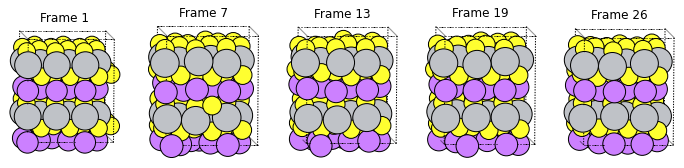

In [25]:
N = 5  # show 5 structures
fig, axes = plt.subplots(1, N, figsize=(12, 5))
nEntries = m3gnet_rb_job.results.readrkf("History", "nEntries")
print(f"There are {nEntries} frames in the trajectory")
ind = np.linspace(1, nEntries, N, endpoint=True, dtype=np.int64)
for ax, i_frame in zip(axes, ind):
    plams.plot_molecule(
        m3gnet_rb_job.results.get_history_molecule(i_frame), ax=ax, rotation="-85x,5y,0z"
    )
    ax.set_title(f"Frame {i_frame}")

It looks like the Li atom is diffusing to the correct place, but it is easiest to visualize in AMSmovie:

In [26]:
!amsmovie "{m3gnet_rb_job.results.rkfpath()}"

**Conclusion**: We have reasonable reaction boost settings for M3GNet-UP-2022. This does not guarantee that the settings will be appropriate with the retrained model (for example because we expect the barrier to be higher), but it is likely to work.

## Run simple active learning using ReactionBoost MD

In [30]:
al_s = plams.Settings()
al_s.input.ams.ActiveLearning.SuccessCriteria.Energy.Relative = 0.0012
al_s.input.ams.ActiveLearning.SuccessCriteria.Forces.MaxDeviationForZeroForce = 0.25
al_s.input.ams.ActiveLearning.Steps.Type = "Linear"
al_s.input.ams.ActiveLearning.Steps.Linear.Start = 15
al_s.input.ams.ActiveLearning.Steps.Linear.StepSize = 50
al_s.input.ams.ActiveLearning.InitialReferenceData.Load.Directory = (
    prelim_al_job2.results.get_reference_data_directory()
)
al_s.input.ams.ActiveLearning.InitialReferenceData.Load.FromPreviousModel = "No"


ml_s = plams.Settings()
ml_s.input.ams.MachineLearning.Backend = "M3GNet"
ml_s.input.ams.MachineLearning.LoadModel = prelim_al_job2.results.get_params_results_directory()
ml_s.input.ams.MachineLearning.MaxEpochs = 200
ml_s.input.ams.MachineLearning.Target.Forces.MAE = 0.03

In [31]:
sal_job = SimpleActiveLearningJob(
    name="sal_lidiffusion_rb",
    settings=al_s + dft_s + ml_s + rb_s,
    molecule={"": defective_1, "final": defective_2},
)
print(sal_job.get_input())

ActiveLearning
  InitialReferenceData
    Load
      Directory /home/hellstrom/temp/sal-lidiff-qMr-2024-Mar-14/clean/plams_workdir.007/al_defective/step7_attempt1_reference_data
      FromPreviousModel False
    End
  End
  Steps
    Linear
      Start 15
      StepSize 50
    End
    Type Linear
  End
  SuccessCriteria
    Energy
      Relative 0.0012
    End
    Forces
      MaxDeviationForZeroForce 0.25
    End
  End
End
MachineLearning
  Backend M3GNet
  LoadModel /home/hellstrom/temp/sal-lidiff-qMr-2024-Mar-14/clean/plams_workdir.007/al_defective/step4_attempt1_training/results
  MaxEpochs 200
  Target
    Forces
      MAE 0.03
    End
  End
End
MolecularDynamics
  InitialVelocities
    Temperature 300.0
    Type Random
  End
  NSteps 500
  ReactionBoost
    NSteps 480
    RMSDRestraint
      Harmonic
        ForceConstant 0.1
      End
      Type Harmonic
    End
    Region DiffusingLi
    TargetSystem final
    Type RMSD
  End
  Thermostat
    Tau 5.0
    Temperature 300.0
    T

In [32]:
# plams.config.jobmanager.hashing = None
sal_job.run(watch=True);

[25.03|13:06:03] JOB sal_lidiffusion_rb STARTED
[25.03|13:06:03] Renaming job sal_lidiffusion_rb to sal_lidiffusion_rb.002
[25.03|13:06:03] JOB sal_lidiffusion_rb.002 RUNNING
[25.03|13:06:04] Simple Active Learning 2024.101,  Nodes: 1, Procs: 8
[25.03|13:06:06] Composition of main system: Li23S48Ti24
[25.03|13:06:06] All REFERENCE calculations will be performed with the following QuantumESPRESSO engine:
[25.03|13:06:06]
Engine quantumespresso
  electrons
    conv_thr 0.0009600000000000001
    mixing_beta 0.3
  End
  k_points gamma
  End
  system
    degauss 0.005
    ecutrho 240.0
    ecutwfc 30.0
    occupations Smearing
  End
EndEngine


[25.03|13:06:06] The following are the settings for the to-be-trained MACHINE LEARNING model:
[25.03|13:06:06]
MachineLearning
  Backend M3GNet
  LoadModel /home/hellstrom/temp/sal-lidiff-qMr-2024-Mar-14/clean/plams_workdir.007/al_defective/step4_attempt1_training/results
  MaxEpochs 200
  Target
    Forces
      MAE 0.03
    End
  End
End

ParallelL

In [33]:
m3gnet_new_s = sal_job.results.get_production_engine_settings()
m3gnet_new_s = prelim_al_job2.results.get_production_engine_settings()

## Run NEB with retrained M3GNet

In [34]:
# constraint_s = plams.Settings()
# constraint_s.input.ams.Constraints.Atom = 8
defective_1_perturbed = defective_1.copy()
defective_1_perturbed.perturb_atoms()
defective_2_perturbed = defective_2.copy()
defective_2_perturbed.perturb_atoms()
m3gnet_new_neb_job = plams.AMSJob(
    settings=m3gnet_new_s + neb_s,  # + constraint_s,
    molecule={"": defective_1, "final": defective_2},
    name="m3gnet_new_neb",
)
m3gnet_new_neb_job.run();

[25.03|15:25:37] JOB m3gnet_new_neb STARTED
[25.03|15:25:37] JOB m3gnet_new_neb RUNNING
[25.03|15:25:58] JOB m3gnet_new_neb FINISHED
[25.03|15:25:58] JOB m3gnet_new_neb SUCCESSFUL


In [35]:
m3gnet_new_res = m3gnet_new_neb_job.results.get_neb_results(unit="eV")
print(f"Left barrier: {m3gnet_new_res['LeftBarrier']:.3f} eV")
print(f"Right barrier: {m3gnet_new_res['RightBarrier']:.3f} eV")

Left barrier: 0.738 eV
Right barrier: 0.738 eV


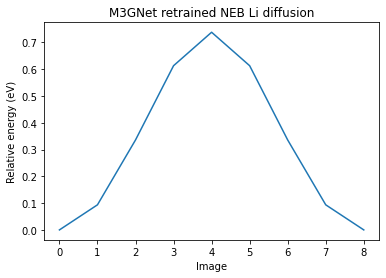

In [36]:
# ref_results = [0.0, 0.144, 0.482, 0.816, 0.963, 0.816, 0.482, 0.144, 0.0]  # from Quantum ESPRESSO DFT calculation
nImages = m3gnet_new_res["nImages"]
relative_energies = np.array(m3gnet_new_res["Energies"]) - m3gnet_new_res["Energies"][0]
plt.plot(relative_energies)
plt.xlabel("Image")
plt.ylabel("Relative energy (eV)")
plt.title("M3GNet retrained NEB Li diffusion");

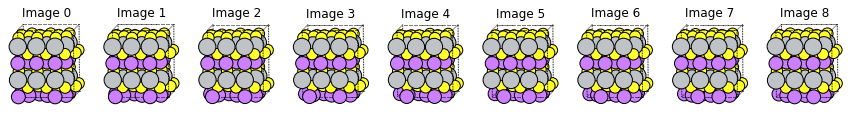

In [37]:
fig, axes = plt.subplots(1, len(m3gnet_new_res["Molecules"]), figsize=(15, 5))

for i, mol in enumerate(m3gnet_new_res["Molecules"]):
    plams.plot_molecule(mol, ax=axes[i], rotation="-85x,-5y,0z")
    axes[i].set_title(f"Image {i}")

Let's run DFT calculations on these frames to compare. We can do this using the "Replay" task.

Note: The DFT calculations may take a few minutes to complete.

In [38]:
replay_s = plams.Settings()
replay_s.input.ams.Task = "Replay"
replay_s.input.ams.Replay.File = os.path.abspath(m3gnet_new_neb_job.results.rkfpath())
replay_s.input.ams.Properties.Gradients = "Yes"

replay_dft_job = plams.AMSJob(settings=replay_s + dft_s, name="replay_m3gnet_new_neb_with_dft")
replay_dft_job.run(watch=True);

[25.03|15:26:03] JOB replay_m3gnet_new_neb_with_dft STARTED
[25.03|15:26:03] JOB replay_m3gnet_new_neb_with_dft RUNNING
[25.03|15:26:03] replay_m3gnet_new_neb_with_dft: AMS 2024.101  RunTime: Mar25-2024 15:26:03  ShM Nodes: 1  Procs: 1
[25.03|15:26:03] replay_m3gnet_new_neb_with_dft: Starting trajectory replay ...
[25.03|15:26:03] replay_m3gnet_new_neb_with_dft: Replaying frame #1/9 (#320 in original trajectory)
[25.03|15:26:03] replay_m3gnet_new_neb_with_dft:     NOTE: a single QE.Label is assigned to atoms of different species.
[25.03|15:26:03] replay_m3gnet_new_neb_with_dft:     Pseudopotentials: /home/hellstrom/.scm/packages/AMS2024.1.packages/qe-ky3v91ot/content/upf_files
[25.03|15:26:04] replay_m3gnet_new_neb_with_dft:     AMS Pseudopotentials Finder:
[25.03|15:26:04] replay_m3gnet_new_neb_with_dft:       * Li
[25.03|15:26:04] replay_m3gnet_new_neb_with_dft:         Path: GGA/PBE/SR/SSSP_Efficiency_v1.3.0/UPFs
[25.03|15:26:04] replay_m3gnet_new_neb_with_dft:         File: li_pbe_

When using "Replay" on a NEB job, the results are stored in the normal NEB format. Thus we can use the ``.get_neb_results()`` method also on this job:

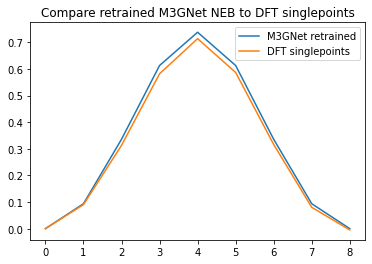

In [39]:
dft_energies = replay_dft_job.results.get_neb_results(unit="eV")["Energies"]
dft_relative_energies = np.array(dft_energies) - dft_energies[0]

plt.plot(relative_energies)
plt.plot(dft_relative_energies)
plt.legend(["M3GNet retrained", "DFT singlepoints"])
plt.title("Compare retrained M3GNet NEB to DFT singlepoints");